<a href="https://colab.research.google.com/github/cisprague/bts-2021/blob/main/notebooks/bts_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# System identification of AUVs with physics-informed learning

Christopher Iliffe Sprague (sprague@kth.se)

Sriharsha Bhat (svbhat@kth.se)

# Outline

- Background
- What's the benefit?
- Data generation
- Model identification
- Simulation
- Discussion and future work

# Resources

In [24]:
# JAX for autograd and and numerics
# ! pip install --upgrade pip
# ! pip install --upgrade "jax[cuda101]" -f https://storage.googleapis.com/jax-releases/jax_releases.html
import jax.numpy as np
from jax import jit, vmap, jacobian, hessian, grad
from jax.experimental.ode import odeint
from jax.random import uniform, choice
from jax.nn import softplus
from jax.lax import stop_gradient

# Haiku for neural networks
# ! pip install git+https://github.com/deepmind/dm-haiku
import haiku as hk

# Optax for optimisation
# ! pip install git+https://github.com/deepmind/optax
import optax

# TQDM for training loop feedback
! pip install tqdm
from tqdm.notebook import tqdm

# SKLearn for preprocessing data
from sklearn.preprocessing import StandardScaler

# treating some arguments as static
from functools import partial

# computer algbra
import sympy

# matplotlib for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [25]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [26]:
key = hk.PRNGSequence(42)

# Derrivation

In [29]:
x, y, z, theta, phi, psi = sympy.symbols(['x', 'y', 'z', '\\phi', '\\theta', '\\psi'])


\theta

# Models

## Properties

In [4]:
# dimensions
dim_state = 12
dim_control = 6

In [7]:
# state and control bounds
bounds_state = (
    np.array([-20, -20, -20, -np.pi, -np.pi, -np.pi, -10, -10, -10, -10, -10, -10]),
    np.array([20, 20, 20, np.pi, np.pi, np.pi, 10, 10, 10, 10, 10, 10])
)
bounds_control = (
    np.full(dim_control, -1.0),
    np.full(dim_control, 1.0)
)

In [8]:
# scaling
scaler = StandardScaler()
scaler.fit(np.vstack(bounds_state))
mean = scaler.mean_
scale = scaler.scale_

In [14]:
# random state and control
state = uniform(
    next(key),
    (dim_state,),
    minval=bounds_state[0],
    maxval=bounds_state[1]
)
control = uniform(
    next(key),
    (dim_control,),
    minval=bounds_control[0],
    maxval=bounds_control[1]
)
state, control

(DeviceArray([-3.509121  ,  7.2579536 , -3.94796   ,  0.8093486 ,
               1.7166288 , -0.16063881,  1.3922167 , -2.2410893 ,
               1.7338371 , -2.5605798 ,  7.6215534 ,  2.5253124 ],            dtype=float32),
 DeviceArray([ 0.8400762 , -0.9023175 ,  0.39534283,  0.4752438 ,
               0.06486011,  0.45205784], dtype=float32))

## Transformations

In [15]:
@jit
def skew(vec):
  return np.array([
    [0, -vec[2], vec[1]],
    [vec[2], 0, -vec[0]],
    [-vec[1], vec[0], 0]
  ])

In [16]:
@jit
def unskew(mat):
    return np.array([
        mat[2,1],
        mat[0,2],
        mat[1,0]
    ])

In [22]:
@jit
def body_to_ned(phi, theta, psi, nu):
    T_euler = np.array([
        [1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)],
    ])
    R_euler = np.array([
        [
            np.cos(psi)*np.cos(theta),
            -np.sin(psi)*np.cos(phi)+np.cos(psi)*np.sin(theta)*np.sin(phi),
            np.sin(psi)*np.sin(phi)+np.cos(psi)*np.cos(phi)*np.sin(theta)
        ],
        [
            np.sin(psi)*np.cos(theta),
            np.cos(psi)*np.cos(phi)+np.sin(phi)*np.sin(theta)*np.sin(psi),
            -np.cos(psi)*np.sin(phi)+np.sin(theta)*np.sin(psi)*np.cos(phi),
        ],
        [
            -np.sin(theta),
            np.cos(theta)*np.sin(phi),
            np.cos(theta)*np.cos(phi),
        ],
    ])
    J_eta = np.block([
        [R_euler, np.zeros((3,3))],
        [np.zeros((3,3)), T_euler]
    ])
    return J_eta.dot(vec)

In [23]:
body_to_ned(*state[3:6], state[3:6])

TypeError: Incompatible shapes for dot: got (6, 6) and (3,).

In [8]:
@jit
def state_to_d_dq(state):

    # extract state
    x, y, z, phi, theta, psi, u, v, w, p, q, r = state

    # rates
    nu = np.array([u, v, w, p, q, r])

    # rotational transform between body and NED in Euler        
    T_euler = np.array([
        [1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)],
    ])
    R_euler = np.array([
        [
            np.cos(psi)*np.cos(theta),
            -np.sin(psi)*np.cos(phi)+np.cos(psi)*np.sin(theta)*np.sin(phi),
            np.sin(psi)*np.sin(phi)+np.cos(psi)*np.cos(phi)*np.sin(theta)
        ],
        [
            np.sin(psi)*np.cos(theta),
            np.cos(psi)*np.cos(phi)+np.sin(phi)*np.sin(theta)*np.sin(psi),
            -np.cos(psi)*np.sin(phi)+np.sin(theta)*np.sin(psi)*np.cos(phi),
        ],
        [
            -np.sin(theta),
            np.cos(theta)*np.sin(phi),
            np.cos(theta)*np.cos(phi),
        ],
    ])
    assert R_euler.shape == (3,3), R_euler
    J_eta = np.block([
        [R_euler, np.zeros((3,3))],
        [np.zeros((3,3)), T_euler]
    ])
    assert J_eta.shape == (6,6), J_eta
    etadot = np.block([J_eta.dot(nu)])

    # cannonical
    q = eta
    dq = etadot
    return q, dq

We will assume that we know the analytical mapping between $q$ and $\dot q$.

## Analytical

In [20]:
@jit
def f_analytical(state, control):

  # state and control
  x, y, z, phi, theta, psi, u, v, w, p, q, r = state
  rpm1, rpm2, de, dr, lcg, vbs = control

  # position and velocity
  eta = np.array([x, y, z, phi, theta, psi])
  nu = np.array([u, v, w, p, q, r])

  # scaled controls
  rpm1 *= 1000.0
  rpm2 *= 1000.0
  de *= 0.05
  dr *= 0.05
  # vbs *= 1.0
  # lcg *= 1.0

  # mass and inertia matrix
  m = 14.0
  I_o = np.diag(np.array([0.0294, 1.6202, 1.6202]))

  # centre of gravity, buoyancy, and pressure positions, resp.
  r_g = np.array([0.1 + lcg*0.01, 0.0, 0.0])
  r_b = np.array([0.1, 0.0, 0.0])
  r_cp = np.array([0.1, 0.0, 0.0])

  # <insert title>
  W = m*9.81
  B = W + vbs*1.5

  # hydrodynamic coefficients
  Xuu = 5. #3. #1.0
  Yvv = 20. #10. #100.0
  Zww = 50. #100.0
  Kpp = 0.1 #10.0
  Mqq = 20.#40 #100.0
  Nrr = 20. #150.0

  # control actuators
  K_T = np.array([0.0175, 0.0175])
  Q_T = np.array([0.001, -0.001])#*0.0

  # mass and inertia matrix
  M = np.block([
    [m*np.eye(3,3), -m*skew(r_g)],
    [m*skew(r_g), I_o]
  ])
  assert M.shape == (6,6), M

  # coriolis and centripetal matrix
  nu1 = np.array([u, v, w])
  nu2 = np.array([p, q, r])
  top_right = -m*skew(nu1) - m*skew(nu2)*skew(r_g)
  bottom_left = -m*skew(nu1) + m*skew(r_g)*skew(nu2)
  bottom_right = -skew(I_o.dot(nu2))
  C_RB = np.block([
    [np.zeros((3,3)), top_right],
    [bottom_left, bottom_right]
  ])
  assert C_RB.shape == (6, 6), C_RB

  # damping matrix
  forces = np.diag(np.array([Xuu*np.abs(u), Yvv*np.abs(v), Zww*np.abs(w)]))
  moments = np.diag(np.array([Kpp*np.abs(p), Mqq*np.abs(q), Nrr*np.abs(r)]))
  coupling = np.matmul(skew(r_cp), forces)
  D = np.block([[forces, np.zeros((3, 3))], [-coupling, moments]])
  assert D.shape == (6, 6), D

  # rotational transform between body and NED in Euler        
  T_euler = np.array([
    [1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
    [0, np.cos(phi), -np.sin(phi)],
    [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)],
  ])
  R_euler = np.array([
    [
      np.cos(psi)*np.cos(theta),
      -np.sin(psi)*np.cos(phi)+np.cos(psi)*np.sin(theta)*np.sin(phi),
      np.sin(psi)*np.sin(phi)+np.cos(psi)*np.cos(phi)*np.sin(theta)
    ],
    [
      np.sin(psi)*np.cos(theta),
      np.cos(psi)*np.cos(phi)+np.sin(phi)*np.sin(theta)*np.sin(psi),
      -np.cos(psi)*np.sin(phi)+np.sin(theta)*np.sin(psi)*np.cos(phi),
    ],
    [
      -np.sin(theta),
      np.cos(theta)*np.sin(phi),
      np.cos(theta)*np.cos(phi),
    ],
  ])
  assert R_euler.shape == (3,3), R_euler
  J_eta = np.block([
    [R_euler, np.zeros((3,3))],
    [np.zeros((3,3)), T_euler]
  ])
  assert J_eta.shape == (6,6), J_eta

  # buoyancy in quaternions
  f_g = np.array([0, 0, W])
  f_b = np.array([0, 0, -B])
  row1 = np.linalg.inv(R_euler).dot(f_g + f_b)
  row2 = skew(r_g).dot(np.linalg.inv(R_euler)).dot(f_g) + \
    skew(r_b).dot(np.linalg.inv(R_euler)).dot(f_b)
  geta = np.block([row1, row2])
  assert geta.shape == (6,), geta

  # <insert title>
  F_T = K_T.dot(np.array([rpm1, rpm2]))
  M_T = Q_T.dot(np.array([rpm1, rpm2]))
  tauc = np.array([
    F_T*np.cos(de)*np.cos(dr),
    -F_T*np.sin(dr),
    F_T*np.sin(de)*np.cos(dr),
    M_T*np.cos(de)*np.cos(dr),
    -M_T*np.sin(dr),
    M_T*np.sin(de)*np.cos(dr)
  ])
  assert tauc.shape == (6,), tauc

  # velocity and acceleration 
  etadot = np.block([J_eta.dot(nu)])
  assert etadot.shape == (6,)
  nudot = np.linalg.inv(M).dot(tauc - (C_RB + D).dot(nu - geta))
  assert nudot.shape == (6,)

  # state-space
  sdot = np.block([etadot, nudot])
  return sdot

## Naïve

In [161]:
def F_naive(state, control):
    q, dq = state_to_d_dq(state)
    net = hk.Sequential([
        hk.Linear(500),
        hk.LayerNorm(axis=-1, create_scale=True, create_offset=True),
        softplus,
        hk.Linear(500),
        hk.LayerNorm(axis=-1, create_scale=True, create_offset=True),
        softplus,
        hk.Linear(500),
        hk.LayerNorm(axis=-1, create_scale=True, create_offset=True),
        softplus,
        hk.Linear(6)
    ])
    # net = hk.nets.MLP([500, 500, 500, 6], activation=softplus)
    ddq = net(np.hstack((q, dq, control)))
    return np.hstack((dq, ddq))

In [71]:
def F_naive(state, control):
  # hk.LayerNorm(axis=-1, create_scale=True, create_offset=True),
  # state = (state - mean)/scale
  # state = np.hstack((np.zeros(3), state[3:]))

  # canonical states
  q, dq = state_to_d_dq(state)

  # 0- and 1-derivative
  x, y, z, phi, theta, psi = q
  dx, dy, dz, dphi, dtheta, dpsi = dq

  # Euler angles to rotation matrix
  Ax = np.array([
    [1, 0, 0],
    [0, np.cos(phi), -np.sin(phi)],
    [0, np.sin(phi), np.cos(phi)]
  ])
  Ay = np.array([
    [np.cos(theta), 0, np.sin(theta)],
    [0, 1, 0],
    [-np.sin(theta), 0, np.cos(theta)]
  ])
  Az = np.array([
    [np.cos(psi), -np.sin(psi), 0],
    [np.sin(psi), np.cos(psi), 0],
    [0, 0, 1]
  ])
  A = Az@Ay@Ax

  # angular velocity -> rotation matrix rate
  dA = skew([dphi, dtheta, dpsi])@A

  # continuous cannonical states
  qc = np.hstack(([x, y, z], A.flatten()))
  dqc = np.hstack(([dx, dy, dz], dA.flatten()))

  # estimate acceleration
  net = hk.Sequential([
    hk.Linear(500),
    hk.LayerNorm(axis=-1, create_scale=True, create_offset=True),
    softplus,
    hk.Linear(500),
    hk.LayerNorm(axis=-1, create_scale=True, create_offset=True),
    softplus,
    hk.Linear(500),
    hk.LayerNorm(axis=-1, create_scale=True, create_offset=True),
    softplus,
    hk.Linear(dim_state)
  ])
  # net = hk.nets.MLP([500, 500, 500, dim_control], activation=softplus)
  ddqc = net(np.hstack((qc, dqc, control)))

  # translational acceleration
  ddx, ddy, ddz = ddqc[0], ddqc[1], ddqc[2]

  # rotation matrix acceleration
  ddA = ddqc[3:].reshape((3,3))

  # angular acceleration
  ddphi, ddtheta, ddpsi = unskew(ddA@A.transpose())

  # cannonical acceleration
  ddq = np.hstack((
    [ddx, ddy, ddz],
    [ddphi, ddtheta, ddpsi]
  ))

  # state rate
  dstate = np.hstack((dq, ddq))
  return dstate

## Physics-informed

In [72]:
def Lagrangian(q, dq):
  net = hk.nets.MLP([500, 500, 500, 1], activation=softplus)
  return net(np.hstack((q, dq)))[0]

In [73]:
def F_conservative(state):
  q, dq = np.split(state, 2)
  ddq = jacobian(jacobian(Lagrangian, 1), 0)(q, dq)
  ddq = ddq @ dq
  ddq = grad(Lagrangian, 0)(q, dq) - ddq
  ddq = np.linalg.pinv(hessian(Lagrangian, 1)(q, dq)) @ ddq
  return np.hstack((dq, ddq))

In [74]:
def F_non_conservative(state, control):
  net = hk.nets.MLP([500, 500, 500, dim_state], activation=softplus)
  return net(np.hstack((state, control)))

In [75]:
def F_decomposition(state, control):
    state = (state - mean)/scale
    dxdt_c = F_conservative(state)
    dxdt_nc = F_non_conservative(state, control)
    return dxdt_c + dxdt_nc

## Random control policy

In [76]:
def Policy(state):
    state = (state - mean)/scale
    net = hk.nets.MLP([500, 500, 500, dim_control], activation=softplus)
    return net(np.hstack((state, control)))

# Integration

In [77]:
@partial(jit, static_argnums=(1,2,3))
def trajectory(x, f, T, h):
    return odeint(f, x, np.arange(0.0, T, h))

In [78]:
trajectories = jit(
    vmap(trajectory, in_axes=(0,None,None,None)),
    static_argnums=(1,2,3)
)

# Visualisation

In [79]:
def plot(trajs_list, markers, labels):

    # setup
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # plot
    for trajs, marker, label in zip(trajs_list, markers, labels):
        for i, traj in enumerate(trajs):
            label = None if i else label
            ax.plot(
                traj[:,0],
                traj[:,1],
                traj[:,2],
                marker,
                label=label
            )

    # format
    plt.legend()
    plt.show()

In [80]:
states = uniform(
    next(key),
    shape=(10, dim_state),
    minval=bounds_state[0],
    maxval=bounds_state[1]
)

f_naive = hk.without_apply_rng(hk.transform(F_naive))
params_naive = f_naive.init(next(key), state, control)

policy = hk.without_apply_rng(hk.transform(Policy))
params_policy = policy.init(next(key), state)

In [115]:
trajs_list = [
    trajectories(
        states,
        lambda x, t: f_analytical(x, policy.apply(params_policy, x)),
        5.0,
        0.01
    ),
    trajectories(
        states,
        lambda x, t: f_naive.apply(params_naive, x, policy.apply(params_policy, x)),
        5.0,
        0.01
    )
]

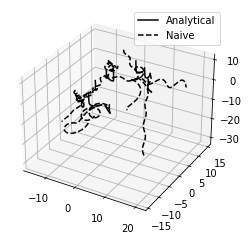

In [116]:
plot(trajs_list, ['k-', 'k--'], ['Analytical', 'Naive'])

# Trainers

In [108]:
class Trainer:

    def __init__(self, F_nn):

        # initialise NN
        self.f_nn = hk.without_apply_rng(hk.transform(F_nn))
        self.params = self.f_nn.init(next(key), state, control)

        # loss record
        self.losses = list()

    def train(self, epo, lr):

        # setup optimiser
        opt_init, opt_update = optax.chain(
            optax.yogi(lr), 
            # optax.scale(-lr)
        )
        opt_state = opt_init(self.params)

        # training loop
        pb = tqdm(range(epo))
        for _ in pb:

            # gradient and loss
            gopt, loss = self.grad(self.params, next(key))

            # record loss
            self.losses.append(loss)

            # progress bar update
            pb.set_description('{:.6f}'.format(loss))

            # optimiser update
            updates, opt_state = opt_update(
                gopt, 
                opt_state, 
                self.params
            )

            # update the parameters
            self.params = optax.apply_updates(self.params, updates)

    @partial(jit, static_argnums=(0,))
    def loss(self, params, key):
        raise NotImplementedError()

    @partial(jit, static_argnums=(0,))
    def grad(self, params, key):
        return grad(self.loss, argnums=0, has_aux=True)(params, key)

## Offline data

In [109]:
class Trainer_Offline(Trainer):

    def __init__(self, F_nn, n):

        # inherit
        Trainer.__init__(self, F_nn)

        # generate random states
        self.states = uniform(
            next(key),
            shape=(n, dim_state),
            minval=bounds_state[0],
            maxval=bounds_state[1]
        )

        # generate random controls
        self.controls = uniform(
            next(key),
            shape=(n, dim_control),
            minval=bounds_control[0],
            maxval=bounds_control[1]
        )

        # time-derivatives
        self.dstates = vmap(f_analytical, in_axes=(0,0))(self.states, self.controls)

    @partial(jit, static_argnums=(0,))
    def loss(self, params, key):

        # NN time-derivative predictions
        dstates_nn = vmap(self.f_nn.apply, in_axes=(None,0,0))(
            params, 
            self.states, 
            self.controls
        )

        # mean-squared error loss
        loss = np.average(np.square(self.dstates - dstates_nn))
        return loss, loss

## Online data

In [110]:
class Trainer_Online:

    def __init__(self, F_nn, n, lr):

        # inherit
        Trainer.__init__(self, F_nn, lr)

        # number of samples
        self.n = n

    @partial(jit, static_argnums=(0,))
    def loss(self, params, key):
        
        # generate random states
        states = uniform(
            key,
            shape=(n, dim_state),
            minval=bounds_state[0],
            maxval=bounds_state[1]
        )

        # generate random controls
        controls = uniform(
            key,
            shape=(n, dim_control),
            minval=bounds_control[0],
            maxval=bounds_control[1]
        )

        # analytical time-derivatives
        dstates = vmap(f_analytical, in_axes=(0,0))(states, controls)

        # compute NN time-derivative predictions
        dstates_nn = vmap(f_nn.apply, in_axes=(None,0,0))(params, states, controls)

        # mean-squared error loss
        loss = np.average(np.square(dstates - dstates_nn))
        return loss, loss

# Results

In [118]:
trainer = Trainer_Offline(F_naive, 20000) 

In [122]:
trainer.train(5000, 2e-2)

  0%|          | 0/5000 [00:00<?, ?it/s]

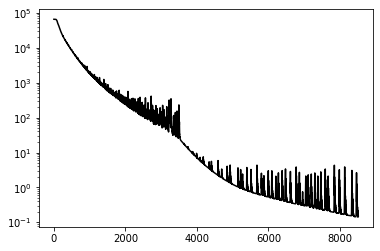

In [114]:
fig, ax = plt.subplots(1)
ax.plot(trainer.losses, 'k-')
ax.set_yscale('log')
plt.show()

In [ ]:
# # a single integration step for a single state
# def rk4_step(f, x, u, h):
#   k1 = f(x, u)
#   k2 = f(x + h*k1/2, u)
#   k3 = f(x + h*k2/2, u)
#   k4 = f(x + h*k3, u)
#   return x + h*(k1 + 2*k2 + 2*k3 + k4)/6